This file is part of https://github.com/diehlpk/reusommer21.

Copyright (c) 2021 Patrick Diehl

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. 
If not, see <http://www.gnu.org/licenses/>.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pgf_with_latex = {"text.usetex": True, "font.size" : 12, "pgf.preamble" : [r'\usepackage{xfrac}'] }

In [2]:
example = "Quartic"
has_condition = True
g = -1
con = []

In [3]:
#############################################################################
# Exact solution 
#############################################################################

def exactSolution(x):
    
    if example == "Cubic":
        return x * x * x
    elif example == "Quartic":
        return x * x * x * x
    elif example == "Quadratic":
        return x * x
    elif example == "Linear":
        return x
    elif example == "Linear-cubic":
        return np.where(x < 1.5, x, x + (x-1.5) * (x-1.5) * (x-1.5) )
    else:
        print("Error: Either provide Linear, Quadratic, Quartic, or Cubic")
        sys.exit()

In [4]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [5]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    global g 

    if example == "Cubic":
        g = 27
        return -6*x
    elif example == "Quartic":
        g = 108
        return -12 * x*x
    elif example == "Quadratic":
        g = 6
        return -2
    elif example == "Linear":
        g = 1
        return 0
    elif example == "Linear-cubic":
        g = 31./4.
        if x < 1.5:
            return 0 
        else:
            return 9-6*x
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,x):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(x[i])
    
    force[n-1] = g
    
    return force

def forceCoupling(n,x):
    
    dim = 2*n + 2*n-1
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i])
    
    force[dim-1] = g
    
    return force

In [6]:
#############################################################################
# Assemble the stiffness matrix for the finite difference model (FD)
#############################################################################

def FDM(n,h):

    M = np.zeros([n,n])

    M[0][0] = 1

    for i in range(1,n-1):
        M[i][i-1] = -2
        M[i][i] = 4
        M[i][i+1] = -2

    
    M[n-1][n-1] = 11*h / 3
    M[n-1][n-2] = -18*h / 3
    M[n-1][n-3] = 9 * h / 3
    M[n-1][n-4] = -2 * h / 3

    M *= 1./(2.*h*h)

    return M

In [7]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - VHM - FDM
#############################################################################

def CouplingFDVHM(n,h):

    fVHM = 1./(8.*h/2*h/2)
    fFDM = 1./(2.*h*h)
    
    dim = 2*n + 2*n-1
    

    M = np.zeros([dim,dim])
    
    M[0][0] = 1 

    for i in range(1,n-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[n-1][n-1] = -1 
    M[n-1][n] = 1  

    M[n][n-1] = 11*h * fFDM / 3
    M[n][n-2] = -18*h * fFDM / 3
    M[n][n-3] = 9*h * fFDM / 3
    M[n][n-4] = -2*h * fFDM / 3

    M[n][n] = 11 / 6 / h *2
    M[n][n+1] = -18 / 6 / h *2
    M[n][n+2] = 9 / 6 / h *2
    M[n][n+3] = -2 / 6 / h *2

    M[n+1][n] = -8 * fVHM
    M[n+1][n+1] = 16 * fVHM
    M[n+1][n+2] = -8 * fVHM
    
    mid = n+2*n -2

    for i in range(n+2,mid-1):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
        
   
        
    M[mid-1][mid-2] = -8 * fVHM
    M[mid-1][mid-1] = 16 * fVHM
    M[mid-1][mid] = -8 * fVHM

    M[mid][mid+1] = -1 
    M[mid][mid] = 1  

    M[mid+1][mid+1-1] = 11 / 6 / h *2
    M[mid+1][mid+1-2] = -18 / 6 / h*2
    M[mid+1][mid+1-3] = 9 / 6 / h*2
    M[mid+1][mid+1-4] = -2 / 6 / h*2

    M[mid+1][mid+1] = 11 *h * fFDM / 3
    M[mid+1][mid+1+1] = -18 *h * fFDM / 3
    M[mid+1][mid+1+2] = 9 *h * fFDM / 3
    M[mid+1][mid+1+3] = -2 *h * fFDM / 3

    for i in range(mid+2,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[dim-1][dim-1] = 11 *  h * fFDM / 3
    M[dim-1][dim-2] =  -18 * h * fFDM  / 3
    M[dim-1][dim-3] = 9 * h * fFDM / 3
    M[dim-1][dim-4] = -2 * h * fFDM / 3
    
    if has_condition:
        con.append(np.linalg.cond(M))

    return M

In [8]:
def compute(i):
    
    n = np.power(2,int(i))
    h = 1./n
    nodes = n + 1
    
    print(nodes,h)
    x1 = np.linspace(0,1,nodes)
    x2 = np.linspace(1,2.,2*nodes-1)
    x3 = np.linspace(2,3.,nodes)
    x = np.array(np.concatenate((x1,x2,x3)))
    
    M = CouplingFDVHM(nodes,h)
    
    f = forceCoupling(nodes,x)
    
    f[n] = 0
    f[n+1] = 0
    
    mid = n+2*n+1

    f[mid] = 0
    f[mid+1] = 0
    
    u = solve(M,f)
    
    x1 = x[0:nodes-1]
    x2 = x[nodes:mid+1:2]
    x3 = x[mid+2:len(x)]
    
    u1 = u[0:nodes-1]
    u2 = u[nodes:mid+1:2]
    u3 = u[mid+2:len(x)]
    
    x = np.concatenate([x1,x2,x3])
    u = np.concatenate([u1,u2,u3])
    
    plt.plot(x,u,label="$hFD=$"+str(h))
    plt.grid(True)
    
    x = np.arange(0,3+h,h)
    interval = int(len(x)/3)
    
    forceFD = forceFull(len(x),x)
    MFD = FDM(len(x),h)
    
    uFM = solve(MFD,forceFD)
    
    print(len(uFM),len(x))
    
    #x1 = x[0:interval:2]
    #x2 = x[interval:2*interval]
    #x3 = x[2*interval:len(x):2]
    #x = np.concatenate([x1,x2,x3])
    
    #uFD1 = uFM[0:interval:2]
    #uFD2 = uFM[interval:2*interval]
    #uFD3 = uFM[2*interval:len(uFM):2]
    #uFD = np.concatenate([uFD1,uFD2,uFD3])
    uFD = uFM
    
    print(len(uFD),len(x))
    print(x)
    
    return u , uFD , x

17 0.0625
49 49
49 49
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625 1.125  1.1875
 1.25   1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875 1.75   1.8125
 1.875  1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125 2.375  2.4375
 2.5    2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375 3.    ]
33 0.03125
97 97
97 97
[0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875 1.      1.03125 1.0625  1.09375
 1.125   1.15625 1.1875  1.21875 1.25    1.28125 1.3125  1.34375 1.375
 1.40625 1.4375  1.46875 1.5     1.53125 1.5625  1.59375 1.625   1.65625
 1.6875  1.71875 1.75    1.78125 1.8125  1.84375 1.875   1.90625 1.9375
 1.96875 2.      2.03125 2.0625  2.09375 2.125   2.15625 2.1875  2.21875
 2.25    2.28125 2.3125  2.34

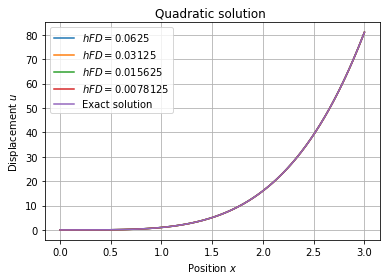

In [9]:
uCoupled = []
uLocal = []
xLocal = []
max_iteration = 8

for i in range(4,max_iteration):
    u , uFD , x = compute(i)
    uCoupled.append(u)
    uLocal.append(uFD)
    xLocal.append(x)

n = np.power(2,int(max_iteration))
h = 1./n

x = np.arange(0,3+h,h)
plt.plot(x,exactSolution(x),label="Exact solution")
plt.legend()
plt.xlabel(r"Position $x$")
plt.ylabel(r"Displacement $u$")
plt.title(r"Quadratic solution ")
plt.savefig("coupling-vhm-"+str(example)+"-dirchelt.pdf")

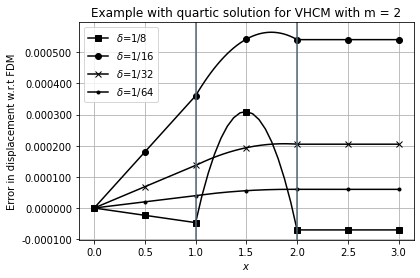

In [10]:
plt.clf()
markers = ['s','o','x','.']
level = [8,16,32,64]

for i in range(0,len(xLocal)):
    #print(xLocal[i])
    #print(uLocal[i])
    n = np.power(2,i+4)
    plt.plot(xLocal[i],uLocal[i]-uCoupled[i],color="black",marker=markers[i],markevery=level[i],label=r"$\delta$=1/"+str(int(n/2)))

    
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.6f'))
plt.xlabel(r"$x$")
plt.ylabel(r"Error in displacement w.r.t FDM")
plt.title(r"Example with " + str(example).lower() + " solution for VHCM with m = 2")
plt.grid()
plt.axvline(x=1,c="#536872")
plt.axvline(x=2,c="#536872")
plt.legend()
plt.savefig("coupling-vhm-"+str(example)+"-neumann-error.pdf",bbox_inches='tight')

if has_condition :
    np.savetxt("con_vhcm_n.csv", con, delimiter=",")